# Active Contours using Parameteric Curves

This tour explores image segmentation using parametric active contours.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$


*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.

In [1]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
options(warn=-1) # turns off warnings, to turn on: "options(warn=0)"


library(imager)
library(png)

source("nt_toolbox/general.R")
source("nt_toolbox/signal.R")

Loading required package: plyr
Loading required package: magrittr

Attaching package: 'imager'

The following object is masked from 'package:magrittr':

    add

The following object is masked from 'package:plyr':

    liply

The following objects are masked from 'package:stats':

    convolve, spectrum

The following object is masked from 'package:graphics':

    frame

The following object is masked from 'package:base':

    save.image



Parameteric Curves
-------------------

In this tours, the active contours are represented using parametric
curve $ \ga : [0,1] \rightarrow \RR^2 $. 


This curve is discretized using a piewise linear curve with 
$p$ segments, and is stored as a complex vector of points in the plane
$\ga \in \CC^p$.

Initial polygon.

In [2]:
gamma0 <- c(.78, .14, .42, .18, .32, .16, .75, .83, .57, .68, .46, .40, .72, .79, .91, .90) + 1i*c(.87, .82, .75, .63, .34, .17, .08, .46, .50, .25, .27, .57, .73, .57, .75, .79)

Display the initial curve.

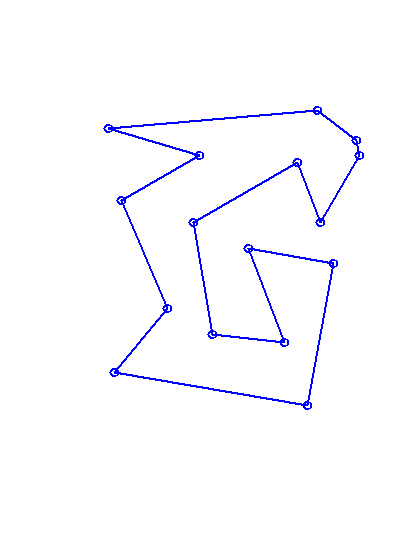

In [3]:
periodize <- function(gamma){ c(gamma, gamma[1]) }

cplot <- function(gamma, type, pch, lty, col, lw=2, add=FALSE){
    if (add==FALSE){
        plot(Re(periodize(gamma)), Im(periodize(gamma)), type=type, pch=pch, lty=lty, col=col, lwd=lw, xaxt='n', yaxt='n', ann=FALSE, bty="n")
    }
    else{
        lines(Re(periodize(gamma)), Im(periodize(gamma)), type=type, pch=pch, lty=lty, col=col, lwd=lw, xaxt='n', yaxt='n', ann=FALSE, bty="n")
    }
    
}

options(repr.plot.width=3.5, repr.plot.height=4.5)

cplot(gamma0, type="o", pch=1, lty=1, col="blue")

Number of points of the discrete curve.

In [4]:
p <- 256

Shortcut to re-sample a curve according to arc length.

In [5]:
interpc <- function(x, xf, yf){ approx(xf, Re(yf), x)$y + 1i*approx(xf, Im(yf), x)$y }
curvabs <- function(gamma){ c(0, cumsum(1e-5 + abs(gamma[1:(length(gamma)-1)]-gamma[2:length(gamma)]))) }
resample1 <- function(gamma, d){ interpc((1:p)/p, d/d[length(d)], gamma)}
resample <- function(gamma){ resample1( periodize(gamma), curvabs(periodize(gamma)) ) }

Initial curve $ \ga_1(t)$.

In [6]:
gamma1 <- resample(gamma0)

Display the initial curve.

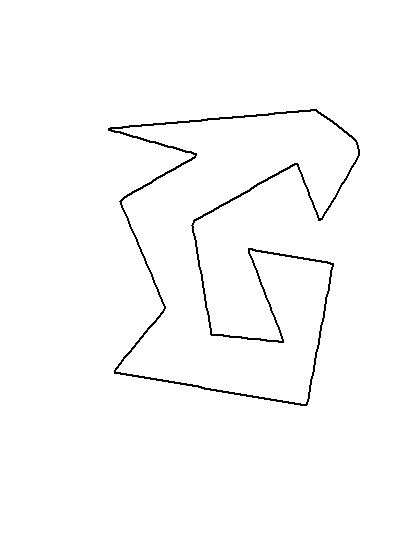

In [7]:
cplot(gamma1, type="l", pch=1, lty=1, col="black")

Shortcut for forward and backward finite differences.

In [8]:
shiftR <- function(c){ c(c[length(c)],c[1:(length(c)-1)]) }
shiftL <- function(c){ c(c[2:length(c)],c[1]) }
BwdDiff <- function(c){ c - shiftR(c) }
FwdDiff <- function(c){ shiftL(c) - c }

The tangent to the curve is computed as
$$ t_\ga(s) = \frac{\ga'(t)}{\norm{\ga'(t)}} $$
and the normal is $ n_\ga(t) = t_\ga(t)^\bot. $

Shortcut to compute the tangent and the normal to a curve.

In [9]:
normalize <- function(v){ return( v/pmax( abs(v), 1e-10 ) ) }
tangent <- function(gamma) { normalize( FwdDiff(gamma) ) }
normal <- function(gamma){ -1i*tangent(gamma) }

Move the curve in the normal direction, by computing $ \ga_1(t) \pm \delta n_{\ga_1}(t) $.

In [10]:
delta <- .03
gamma2 <- gamma1 + delta * normal(gamma1)
gamma3 <- gamma1 - delta * normal(gamma1)

Display the curves.

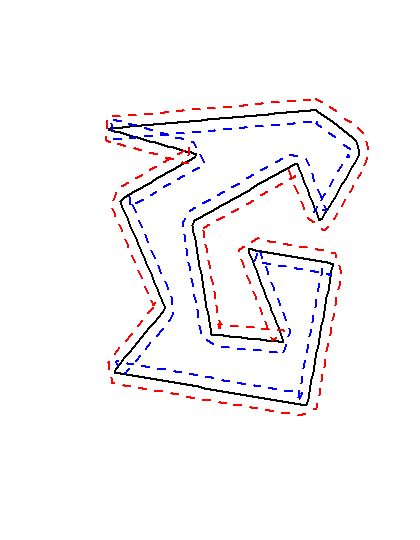

In [11]:
cplot(gamma1, type="l", pch=1, lty=1, col="black")
cplot(gamma2, type="l", pch=1, lty=2, col="red", add=TRUE)
cplot(gamma3, type="l", pch=1, lty=2, col="blue", add=TRUE)

## Evolution by Mean Curvature

A curve evolution is a series of curves $ s \mapsto \ga_s $ indexed by
an evolution parameter $s \geq 0$. The intial curve $\ga_0$ for
$s=0$ is evolved, usually by minizing some energy $E(\ga)$ in a gradient descent
$$ \frac{\partial \ga_s}{\partial s} = \nabla E(\ga_s). $$


Note that the gradient of an energy is defined with respect to the
curve-dependent inner product
$$ \dotp{a}{b} = \int_0^1 \dotp{a(t)}{b(t)} \norm{\ga'(t)} d t.  $$
The set of curves can thus be thought as being a Riemannian surface.


The simplest evolution is the mean curvature evolution.
It corresponds to minimization of the curve length
$$ E(\ga) = \int_0^1 \norm{\ga'(t)} d t $$


The gradient of the length is 
$$ \nabla E(\ga)(t) = -\kappa_\ga(t) n_\ga(t)  $$
where $ \kappa_\ga $ is the curvature, defined as
$$ \kappa_\ga(t) = \frac{1}{\norm{\ga'(t)}} \dotp{ t_\ga'(t) }{ n_\ga(t) } . $$



Shortcut for normal times curvature $ \kappa_\ga(t) n_\ga(t) $.

In [12]:
normalC <- function(gamma){ BwdDiff(tangent(gamma)) / abs( FwdDiff(gamma) ) }

Time step for the evolution.
It should be very small because we use an explicit time stepping and the
curve has strong curvature.

In [13]:
dt <- 0.001 / 100

Number of iterations.

In [14]:
Tmax <- 3.0 / 100
niter <- round(Tmax/dt)

Initialize the curve for $s=0$.

In [15]:
gamma <- gamma1

Evolution of the curve.

In [16]:
gamma <- gamma + dt * normalC(gamma)

To stabilize the evolution, it is important to re-sample the curve so
that it is unit-speed parametrized. You do not need to do it every time
step though (to speed up).

In [17]:
gamma <- resample(gamma)

**Exercise 1:** Perform the curve evolution.
You need to resample it a few times.

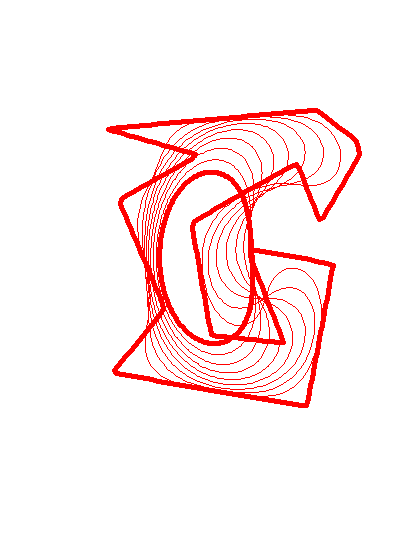

In [18]:
source("nt_solutions/segmentation_2_snakes_param/exo1.R")

## Geodesic Active Contours

Geodesic active contours minimize a weighted length
$$ E(\ga) = \int_0^1 W(\ga(t)) \norm{\ga'(t)} d t, $$
where $W(x)>0$ is the geodesic metric, that should be small in areas
where the image should be segmented.

Size of the image $n$.

In [19]:
n <- 200

Create a synthetic weight $W(x)$.

In [20]:
nbumps <- 40
theta <- runif(nbumps)*2*pi
r <- .6*n/2
a <- c(.62*n,.6*n)
x <- round(a[1] + r*cos(theta))
y <- round(a[2] + r*sin(theta))
W <- matrix(rep(0, n*n), c(n,n))
for (i in 1:nbumps){
    W[x[i], y[i]] <- 1
}
W <- gaussian_blur(W,6.0)
W <- rescale( -apply(W, c(1,2), min, 0.05), .3,1)

Display the metric $W$.

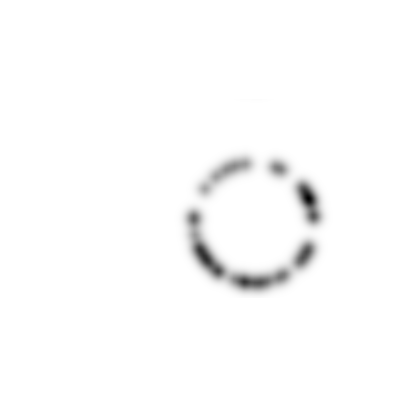

In [21]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

imageplot(W)

Pre-compute the gradient $\nabla W(x)$ of the metric.

In [22]:
G <- grad(W)
G <- G[,,1] + 1i*G[,,2]

Display the image of the magnitude $\norm{\nabla W(x)}$ of the gradient.

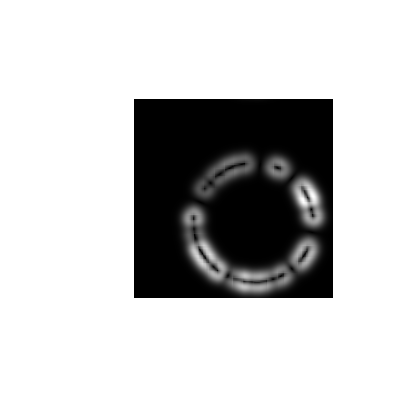

In [23]:
imageplot(abs(G))

Shortcut to evaluate the gradient and the potential along a curve.

In [24]:
EvalG <- function(gamma){ bilinear_interpolate(G, Im(gamma), Re(gamma)) }
EvalW <- function(gamma){ bilinear_interpolate(W, Im(gamma), Re(gamma)) }

Create a circular curve $\ga_0$.

In [25]:
r <- .98*n/2 # radius
p <- 128 # number of points on the curve
theta <- t( seq(0,2*pi,length=p+1) )
theta <- theta[1:length(theta)-1]
gamma0 <- n/2 * (1 + 1i) +  r*(cos(theta) + 1i*sin(theta))

Initialize the curve at time $t=0$ with a circle.

In [26]:
gamma <- gamma0

For this experiment, the time step should be larger, because the
curve is in $[0,n-1] \times [0,n-1]$.

In [27]:
dt <- 1

Number of iterations.

In [28]:
Tmax <- 5000
niter <- round(Tmax/dt)

Display the curve on the background.

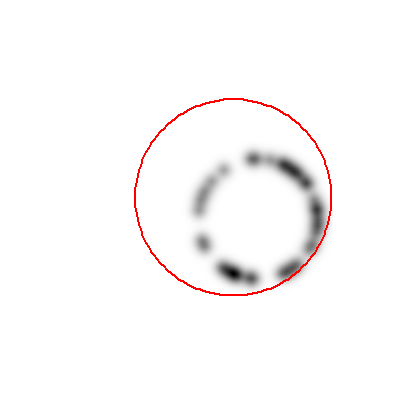

In [29]:
lw <- 2
imageplot(t(W))
cplot(gamma, type="l", pch=1, lty=1, col="red", add=TRUE)

The gradient of the energy is
$$ \nabla E(\ga) = -W(\ga(t)) \kappa_\ga(t) n_\ga(t) + \dotp{\nabla W(\ga(t))}{ n_\ga(t) } n_\ga(t). $$

Pointwise innerproduct on the curve.

In [30]:
dotp <- function(c1,c2){ Re(c1)*Re(c2) + Im(c1)*Im(c2) }

Evolution of the curve according to this gradient.

In [31]:
N <- normal(gamma)
g <- - EvalW(gamma) * normalC(gamma) + dotp(EvalG(gamma), N) * N
gamma <- gamma - dt*g

To avoid the curve from being poorly sampled, it is important to
re-sample it evenly.

In [32]:
gamma <- resample(gamma)

**Exercise 2:** Perform the curve evolution.

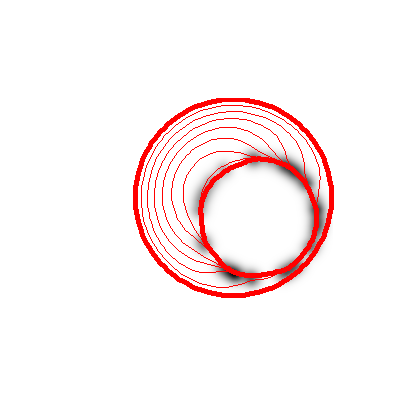

In [33]:
source("nt_solutions/segmentation_2_snakes_param/exo2.R")

# Medical Image Segmentation

One can use a gradient-based metric to perform edge detection in medical
images.

Load an image $f$.

In [34]:
n <- 256
name <- 'nt_toolbox/data/cortex.png'
f <- as.matrix(load_image(name, n))

Display.

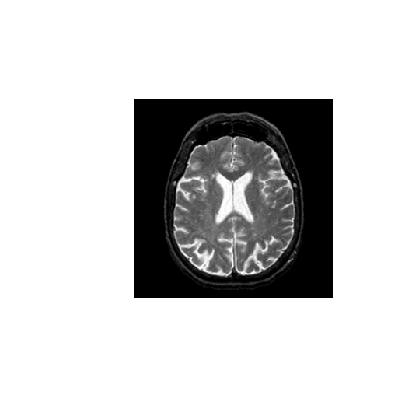

In [35]:
imageplot(f)

An edge detector metric can be defined as a decreasing function of the
gradient magnitude.
$$ W(x) = \psi( d \star h_a(x) )
      \qwhereq d(x) = \norm{\nabla f(x)}. $$
where $h_a$ is a blurring kernel of width $a>0$.

Compute the magnitude of the gradient.

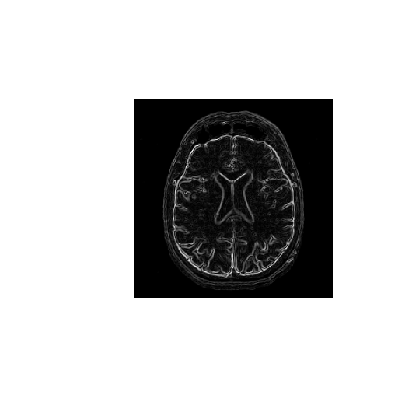

In [36]:
G <- grad(f)
d0 <- sqrt(apply(G**2, c(1,2), sum))
imageplot(d0)

Blur it by $h_a$.

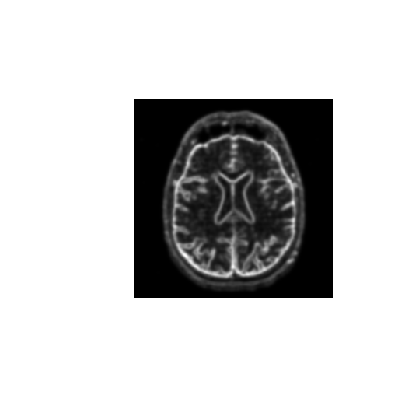

In [37]:
a <- 2
d <- gaussian_blur(d0, a)
imageplot(d)

Compute a decreasing function of the gradient to define $W$.

In [38]:
d <- pmin(d, 0.4)
W <- rescale(-d, .8, 1)

Display it.

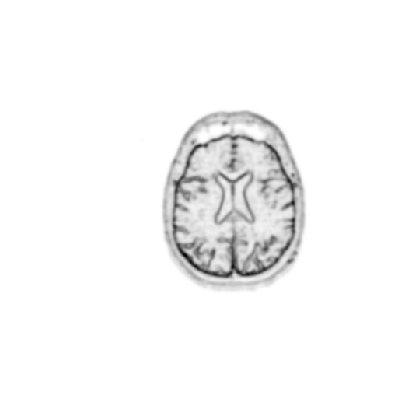

In [39]:
imageplot(W)

Number of points.

In [40]:
p <- 128

**Exercise 3:** Create an initial circle $\gamma_0$ of $p$ points. When plotting the image, you need to transpose it to have axis coherent with the cplot.

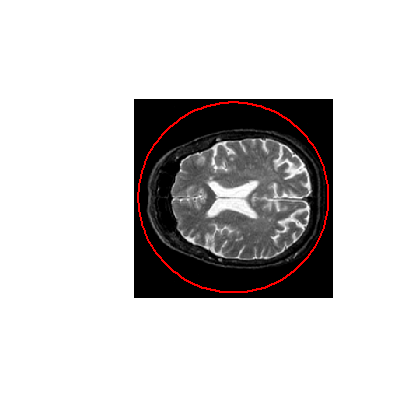

In [41]:
source("nt_solutions/segmentation_2_snakes_param/exo3.R")

Step size.

In [42]:
dt <- 2

Number of iterations.

In [43]:
Tmax <- 9000
niter <- round(Tmax/ dt)

**Exercise 4:** Perform the curve evolution.

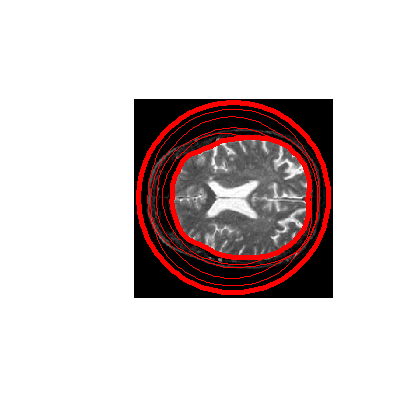

In [44]:
source("nt_solutions/segmentation_2_snakes_param/exo4.R")

# Evolution of a Non-closed Curve

It is possible to perform the evolution of a non-closed curve by adding
boundary constraint
$$ \ga(0)=x_0 \qandq \ga(1)=x_1. $$


In this case, the algorithm find a local minimizer of the geodesic
distance between the two points.


Note that a much more efficient way to solve this problem is to use the
Fast Marching algorithm to find the global minimizer of the geodesic
length.


Load an image $f$.

In [45]:
n <- 256
f <- as.matrix(load_image(name, n))
f <- f[46:105, 61:120]
n <- dim(f)[1]

Display.

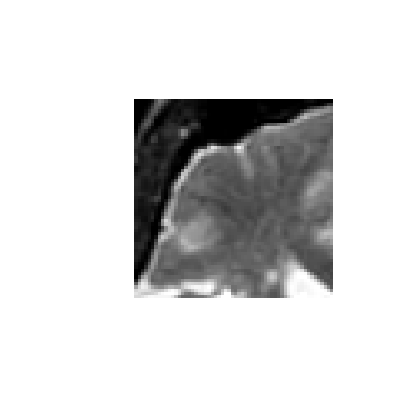

In [46]:
imageplot(f)

**Exercise 5:** Compute an edge attracting criterion $W(x)>0$, that is small in area of strong
gradient.

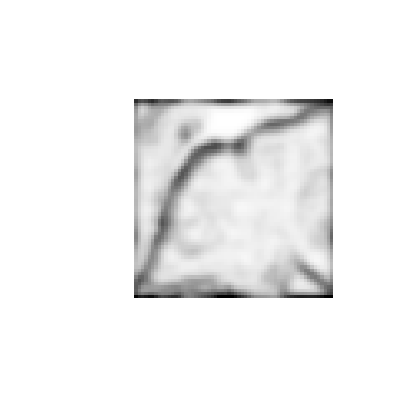

In [47]:
source("nt_solutions/segmentation_2_snakes_param/exo5.R")

Start and end points $x_0$ and $x_1$.

In [48]:
x0 <- 4 + 55i
x1 <- 53 + 4i

Initial curve $\ga_0$.

In [49]:
p <- 128
t <- t(seq(0, 1, length=p))
gamma0 <- t*x1 + (1-t)*x0

Initialize the evolution.

In [50]:
gamma <- gamma0

Display.

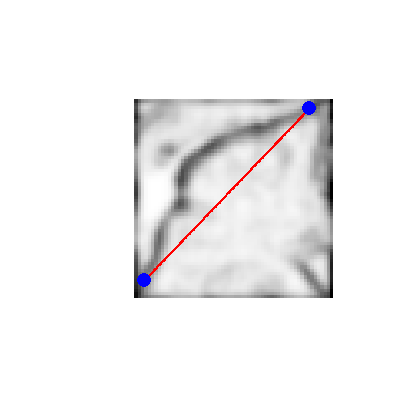

In [51]:
imageplot(t(W))
cplot(gamma, type="l", pch=1, lw=2, lty=1, col="red", add=TRUE)
points(Re(gamma[1]), Im(gamma[1]), pch=16, cex=1.5, col="blue")
points(Re(gamma[length(gamma)]), Im(gamma[length(gamma)]), pch=16, cex=1.5, col="blue")

Re-sampling for non-periodic curves.

In [52]:
curvabs <- function(gamma){ c(0, cumsum(1e-5 + abs(gamma[1:(length(gamma)-1)]-gamma[2:length(gamma)]))) }
resample1 <- function(gamma, d){ interpc((1:p)/p, d/d[length(d)], gamma)}
resample <- function(gamma){ resample1( gamma, curvabs(gamma) ) }

Time step.

In [53]:
dt <- 1/10

Number of iterations.

In [54]:
Tmax <- 2000*4/ 7
niter <- round(Tmax/ dt)

**Exercise 6:** Perform the curve evolution.
Be careful to impose the boundary conditions at each step.

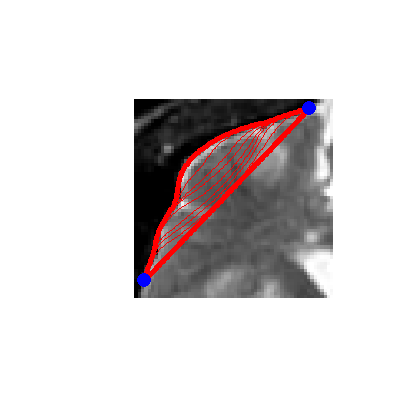

In [55]:
source("nt_solutions/segmentation_2_snakes_param/exo6.R")